In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy import pad
from model.Model import Model
from preprocess.preprocess import Dataset, PreprocessFrame

In [10]:
ls

EDA.html*                  README.md*   metadata/      preprocess/
HKR_Dataset_Words_Public/  arxivs/      model/         requirements.txt*
LICENSE*                   dockerfile*  mts-env.yaml*  run.ipynb*


In [4]:
# images size
img_width = 600
img_height = 100

new_img_width = 300
new_img_height = 50

batch_size = 16

# default paths
WORKING_DIR = os.path.join('/home', 'MTS')
ann_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'ann')
img_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'img')
metadata = os.path.join(WORKING_DIR, 'metadata', 'metadata.tsv')

In [5]:
# collect metadata
# meta_collect(ann_path, metadata)

# get preprocessed metadata dataframe
df = PreprocessFrame(metadata=metadata,
                     img_height=img_height, img_width=img_width)
print(df.shape)

# Make augments file (if they exists: comment or delete line)
aug_df = None
aug_df = make_augments(df=df, img_path=img_path, WORKING_DIR=WORKING_DIR,
                        img_height=img_height, img_width=img_width)

# get augments metadata dataframe from original dataframe if not starting make_augments
if not isinstance(aug_df, pd.DataFrame):
    aug_df = df.copy()
    aug_df.index = aug_df.index.to_series().apply(lambda x: os.path.join('aug_1', 'aug_' + x))

train, test, val = list(Dataset(df, aug_df=aug_df,
                                test_size=0.1,
                                val_size=0.05,
                                img_path=img_path,
                                img_height=img_height,
                                img_width=img_width,
                                new_img_height=new_img_height,
                                new_img_width=new_img_width,
                                WORKING_DIR=WORKING_DIR,
                                shuffle=True,
                                random_state=12))
train

(48419, 4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [04:07<00:00,  2.55s/it]
2021-08-10 16:00:18.408472: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


<PrefetchDataset shapes: {image: (None, 300, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

In [15]:
r'''
params:

callbacks: list of callback names [checkpoint, csv_log, tb_log, early_stopping]
metrics: list of metrics name [cer, wer, accuracy, ctc_loss]

checkpoint_path
csv_log_path
tb_log_path
  tb_update_freq: int

early_stopping
    early_stopping_patience: int

input_img_shape: array(width, height, 1)

vocab_len: len of vocab with blank
restore_weights: bool
max_label_len
chars_path
blank - '#'
'''

params = {
    'callbacks': ['checkpoint', 'csv_log', 'tb_log', 'early_stopping'],
    'metrics': ['cer', 'accuracy'],
    'checkpoint_path': os.path.join(WORKING_DIR, 'checkpoints/training_0/cp.ckpt'),
    'csv_log_path': os.path.join(WORKING_DIR, 'logs/csv_logs/log_0.csv'),
    'tb_log_path': os.path.join(WORKING_DIR, 'logs/tb_logs/log0'),
    'tb_update_freq': 200,
    'epochs': 50,
    'batch_size': batch_size,
    'restore_weights': True,
    'early_stopping_patience': 10,
    'input_img_shape': (new_img_width, new_img_height, 1),
    'vocab_len': 75,
    'max_label_len': 22,
    'chars_path': os.path.join(os.path.split(metadata)[0], 'symbols.txt'),
    'blank': '#',
    'blank_index': 74
}

In [16]:
model = Model(params)
model.build()

In [18]:
model.fit(train, val)

Epoch 1/50
   2/5599 [..............................] - ETA: 32:31 - loss: 119.0648 - cer: 0.9854 - accuracy: 0.0000e+00  5599/5599 [==============================] - 760s 135ms/step - loss: 24.7669 - cer: 0.7400 - accuracy: 0.0102 - val_loss: 10.0049 - val_cer: 0.2843 - val_accuracy: 0.1362

Epoch 00001: val_loss improved from inf to 10.00488, saving model to /workspace/pybooks/MTS/checkpoints/training_0/cp.ckpt
Epoch 2/50
5599/5599 [==============================] - 763s 136ms/step - loss: 11.8854 - cer: 0.3452 - accuracy: 0.1603 - val_loss: 5.1547 - val_cer: 0.1540 - val_accuracy: 0.3788

Epoch 00002: val_loss improved from 10.00488 to 5.15471, saving model to /workspace/pybooks/MTS/checkpoints/training_0/cp.ckpt
Epoch 3/50
5599/5599 [==============================] - 760s 136ms/step - loss: 9.0670 - cer: 0.2655 - accuracy: 0.2811 - val_loss: 3.9157 - val_cer: 0.1206 - val_accuracy: 0.4861

Epoch 00003: val_loss improved from 5.15471 to 3.91568, saving model to /workspace/pybooks/MT

In [41]:
def show_history(history, indicators, nrows=2, ncols=2, width=15, height=10):
    _, ax = plt.subplots(nrows, ncols, figsize=(width, height))
    for i in range(min(len(indicators), nrows*ncols)):
        indicator_name = indicators[i]
        ax[i // ncols, i % ncols].plot(history.history[indicator_name])
        ax[i // ncols, i % ncols].plot(history.history['val_' + indicator_name])
        ax[i // ncols, i % ncols].set_title('Model ' + indicator_name)
        ax[i // ncols, i % ncols].set_ylabel(indicator_name)
        ax[i // ncols, i % ncols].set_xlabel('epoch')
        ax[i // ncols, i % ncols].legend(['Train', 'Val'], loc='lower left')
    plt.show()

In [42]:
history = model.get_history()

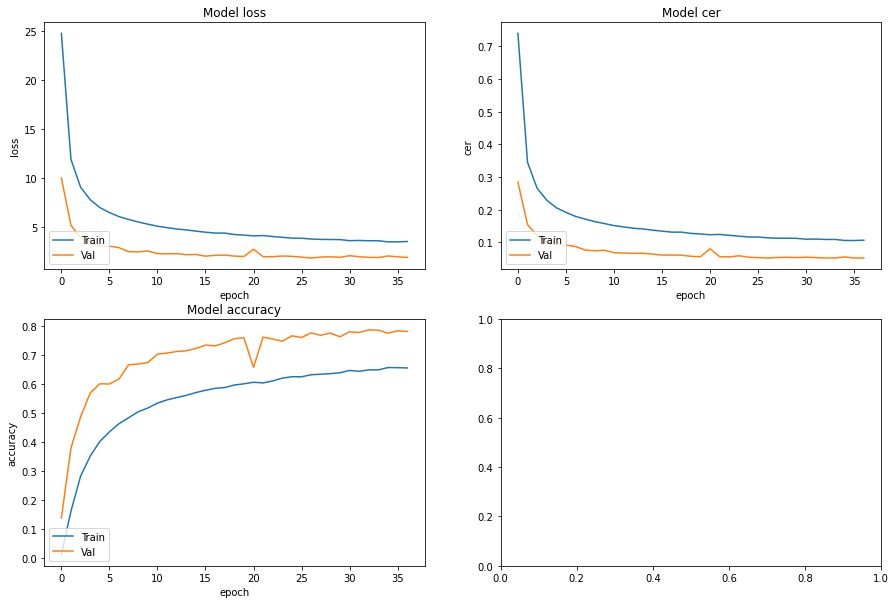

In [43]:
show_history(history, ['loss', 'cer', 'accuracy'])

In [1]:
model.evaluate(test)

NameError: name 'model' is not defined

In [45]:
def show_preds_on_batch(model, batch, batch_size=batch_size):
    _, ax = plt.subplots(batch_size, 1, figsize=(10, 50))

    batch_images = batch['image']
    batch_labels = batch['label']

    pred_texts = model.predict(batch)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8').replace('#', '')
        orig_texts.append(label)
    for i in range(batch_size):
        img = ((batch_images[i, :, :, 0] + 0.5) * 255).numpy().astype('uint8')
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nOriginal: {orig_texts[i]}"
        ax[i].set_title(title)
        ax[i].imshow(img, cmap="gray")

1/1 [==============================] - 0s 45ms/step - loss: 2.6319 - cer: 0.0714 - accuracy: 0.7500


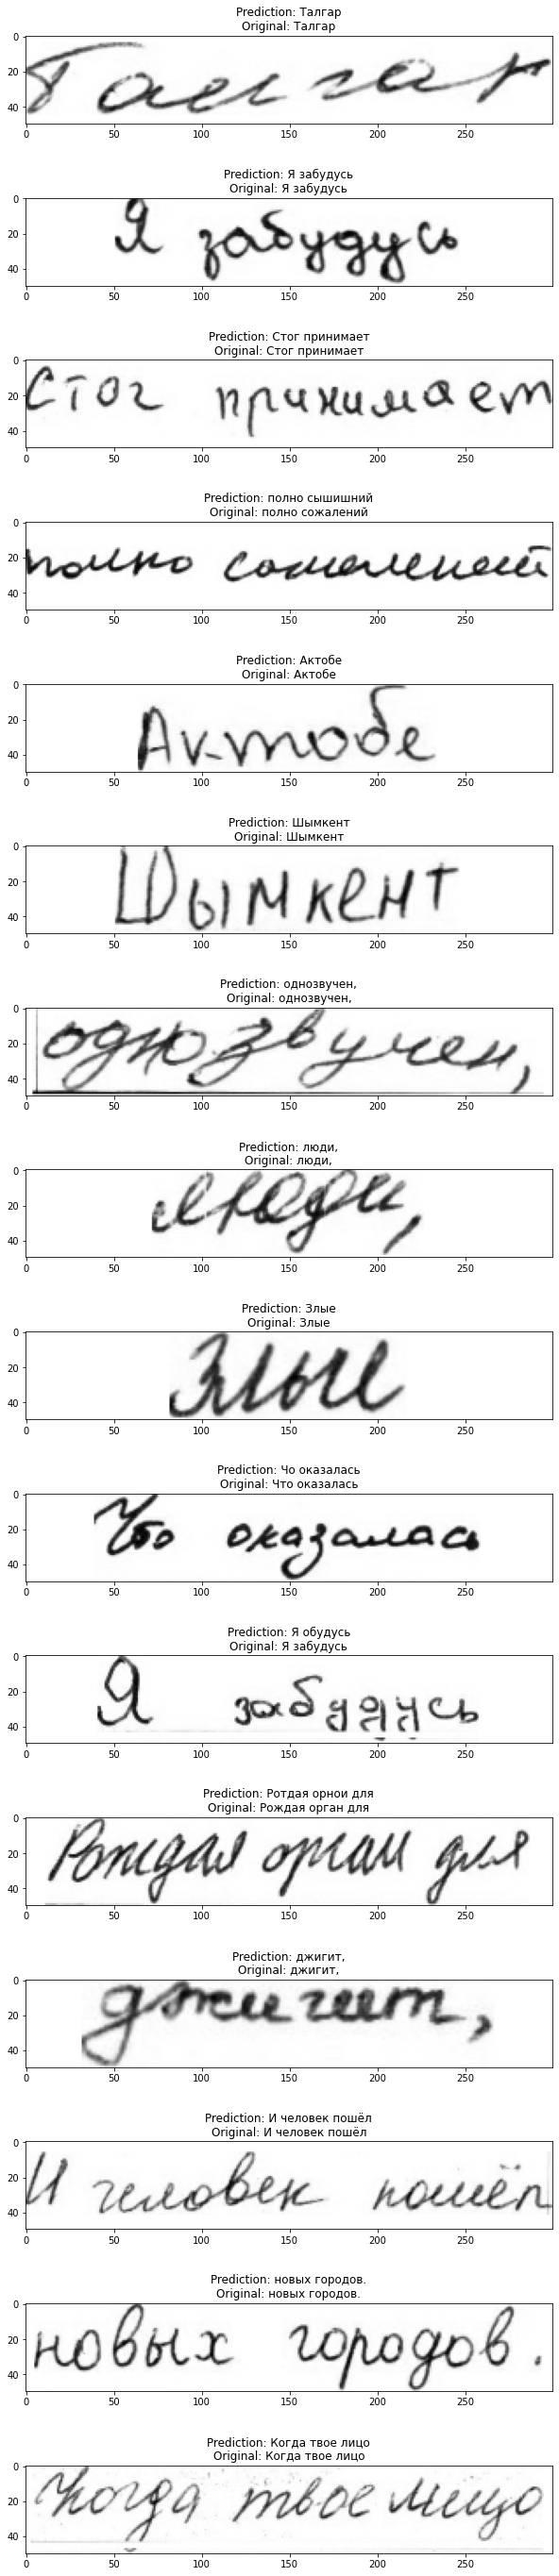

In [46]:
for batch in test.take(1):
    model.evaluate(batch)
    show_preds_on_batch(model, batch)